In [170]:
import lifelines
import pymc as pm
from pyBMA.CoxPH import CoxPH
import matplotlib.pyplot as plt
import numpy as np
from math import log
import pandas as pd
%matplotlib inline  

The first step in any data analysis is acquiring and munging the data
An example data set can be found HERE

Download the file output.txt and transform it into a format like below where the censored column should be 1 if there's only one entry for an id, and 0 if there are two entries:

id,time_to_convert,censored


In [210]:
#Solution to part one:
def convert_to_minutes(dt):
    day_diff = dt / np.timedelta64(1, 'D')
    if day_diff == 0:
        return 14
    else: 
        return day_diff
df = pd.read_csv("E:/output.txt")
df["time_to_convert"] = pd.to_datetime(df['datetime'])
df = df.drop('datetime', 1)
time_deltas = df.groupby(by = "id").max() - df.groupby(by = "id").min()
df = time_deltas["time_to_convert"].apply(convert_to_minutes).to_frame()
df["censored"] = df["time_to_convert"] == 14.0
df["censored"] = df["censored"].apply(lambda x: 1 if x else 0)
df

,time_to_convert,censored
id,,
1,11.689711,0
2,0.956768,0
3,1.026633,0
4,12.969889,0
5,4.232592,0
6,14.000000,1
7,14.000000,1
8,1.088168,0
9,2.740862,0


In [ ]:
###Parametric Bayes
#Shout out to Cam Davidson-Pilon

In [214]:
## Example fully worked model using toy data
## Adapted from http://blog.yhat.com/posts/estimating-user-lifetimes-with-pymc.html

alpha = mc.Uniform("alpha", 0,20) 
beta = mc.Uniform("beta", 0,20) 
obs = mc.Weibull('obs', alpha, beta, value = df["time_to_convert"], observed = True )

@mc.potential
def censorfactor(obs=obs): 
    if np.any(obs>14 ): 
        return -100000
    else:
        return 0

mcmc = mc.MCMC([alpha, beta, obs, censorfactor ] )
mcmc.sample(50000, burn = 10, thin = 1)

 [-----------------100%-----------------] 50000 of 50000 complete in 5.4 sec

Plotting beta
Plotting alpha


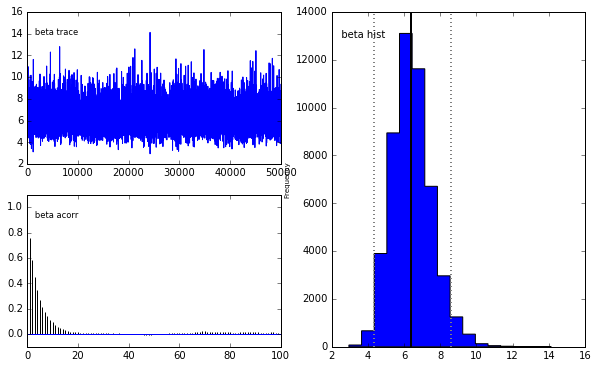

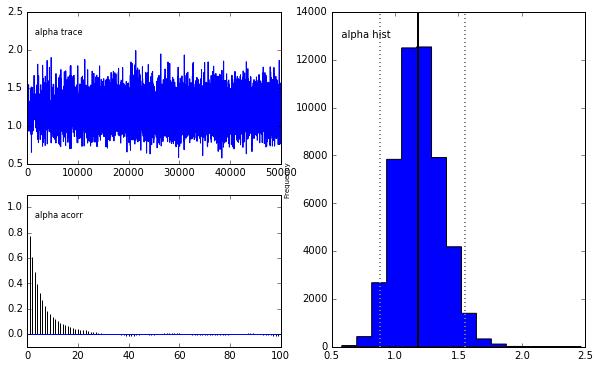

In [215]:
pm.Matplot.plot(mcmc)

Problems: 

    1 - Work out the mean observed time to convert
    2 - Try to fit your data from section 1 
    3 - Use the results to plot the distribution of the median
    4 - Try adjusting the number of samples, the burn parameter and the amount of thinning to correct get good answers
    5 - Try adjusting the prior and see how it affects the estimate
    6 - Try to fit a different distribution to the data
    7 - Compare answers
    Bonus - test the hypothesis that the true median is greater than a certain amount
    
For question 2, note that the median of a Weibull is:

$$β(log 2)^{1/α}$$
    

(array([  8.10000000e+01,   1.61600000e+03,   9.73700000e+03,
          1.86220000e+04,   1.35680000e+04,   4.97600000e+03,
          1.14000000e+03,   2.07000000e+02,   3.60000000e+01,
          7.00000000e+00]),
 array([ 1.62757904,  2.43921027,  3.25084149,  4.06247271,  4.87410394,
         5.68573516,  6.49736639,  7.30899761,  8.12062883,  8.93226006,
         9.74389128]),
 <a list of 10 Patch objects>)

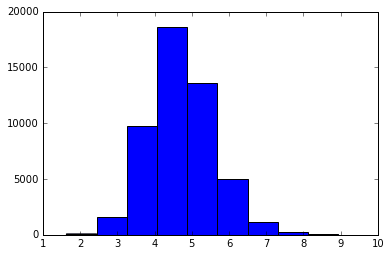

In [213]:
#Solution to question 4:
def weibull_median(alpha, beta):
    return beta * ((log(2)) ** ( 1 / alpha))
plt.hist([weibull_median(x[0], x[1]) for x in zip(mcmc.trace("alpha"), mcmc.trace("beta"))])

In [ ]:
#Solution to question 4:
### Increasing the burn parameter allows us to discard results before convergence
### Thinning the results removes autocorrelation

mcmc = mc.MCMC([alpha, beta, obs, censorfactor ] )
mcmc.sample(50000, burn = 30000, thin = 20)

pm.Matplot.plot(mcmc)

 [-----------------100%-----------------] 50000 of 50000 complete in 3.2 sec

(array([   8.,   20.,   53.,   82.,  162.,  248.,  315.,  348.,  208.,   56.]),
 array([ 2.64229817,  2.8537489 ,  3.06519963,  3.27665036,  3.48810109,
         3.69955182,  3.91100256,  4.12245329,  4.33390402,  4.54535475,
         4.75680548]),
 <a list of 10 Patch objects>)

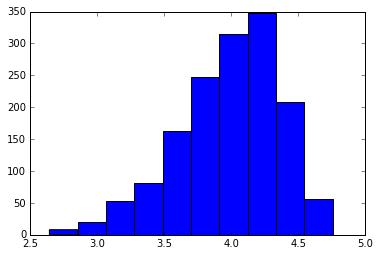

In [216]:
#Solution to Q5
## Adjusting the priors impacts the overall result
## If we give a looser, less informative prior then we end up with a broader, shorter distribution
## If we give much more informative priors, then we get a tighter, taller distribution


## Note the narrowing of the prior around the true values
alpha = mc.Uniform("alpha", 1, 3) 
beta = mc.Uniform("beta", 3, 6) 

####Uncomment this to see the result of looser priors
#alpha = mc.Uniform("alpha", 0, 30) 
#beta = mc.Uniform("beta", 0, 30) 

obs = mc.Weibull( 'obs', alpha, beta, value = df["time_to_convert"], observed = True )

mcmc = mc.MCMC([alpha, beta, obs, censorfactor ] )
mcmc.sample(50000, burn = 20000, thin = 20)
#pm.Matplot.plot(mcmc)
plt.hist([weibull_median(x[0], x[1]) for x in zip(mcmc.trace("alpha"), mcmc.trace("beta"))])

 [-----------------100%-----------------] 50000 of 50000 complete in 3.5 sec

(array([  60.,   93.,  134.,  184.,  170.,  146.,  118.,   52.,   28.,   15.]),
 array([  1.02411690e-04,   1.44070931e+00,   2.88131620e+00,
          4.32192310e+00,   5.76252999e+00,   7.20313688e+00,
          8.64374378e+00,   1.00843507e+01,   1.15249576e+01,
          1.29655645e+01,   1.44061714e+01]),
 <a list of 10 Patch objects>)

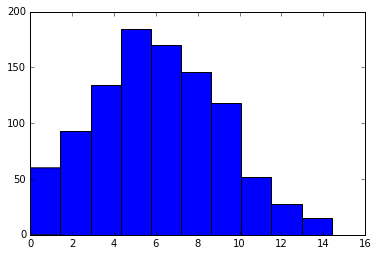

In [219]:
#Solution to Q6
## To fit a new distribution to the data, we need to change the obs variable to a new distribution.
## This requires creating new hyper parameters,
## The normal distribution has two parameters, the mean and the stdev (we use 1/stdev in pymc)

import pymc as mc
import numpy.ma as ma

#this begins the model 
alpha = mc.Uniform("mean", 0,15) 
tau = mc.Uniform("tau", 0, 0.01)
obs = mc.Normal( 'obs', alpha, tau, value = df["time_to_convert"], observed = True )

mcmc = mc.MCMC([alpha, beta, obs, censorfactor ] )
mcmc.sample(50000, burn = 30000, thin = 20)
#pm.Matplot.plot(mcmc)
plt.hist(mcmc.trace("mean")[:])

In [220]:
## Solution to bonus
## Super easy to do in the Bayesian framework, all we need to do is look at what % of samples
## meet our criteria

testing_value = 4
number_of_greater_samples = sum([x >= testing_value for x in mcmc.trace("mean")[:]])
100 * (number_of_greater_samples / len(mcmc.trace("mean")[:]))

74.799999999999997

In [ ]:
#Cox model

If we want to look at covariates, we need a new approach.  We'll use Cox proprtional hazards.  More information here.

In [ ]:
#Fitting solution
cf = lifelines.CoxPHFitter()
cf.fit(data, 'week', event_col = 'arrest')

Once we've fit the data, we need to do something useful with it.  Try to do the following things:

    1 - Plot the cumulative baseline hazard and survival function

            What relation do these have?

    2 - Predict the functions for a particular set of regressors

    3 - Plot the survival function for two different set of regressors

    4 - For your results in part 3 caculate how much more likely a death event is for one than the other for a given period of time

In [ ]:
#Solution to 1
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey = True)
cf.baseline_cumulative_hazard_.plot(ax = axes[0], title = "Baseline Cumulative Hazard")
cf.baseline_survival_.plot(ax = axes[1], title = "Baseline Survival")
print("Survival is the 1 - Cumulative hazard")

In [ ]:
# Solution to prediction
regressors = np.array([[0,0,0,0,0,0,0]])
survival = cf.predict_survival_function(regressors)

In [ ]:
#Solution to plotting multiple regressors
fig, axis = plt.subplots(nrows=1, ncols=1, sharex=True)
regressor1 = np.array([[0,0,0,0,0,0,0]])
regressor2 = np.array([[1,1,1,1,1,1,1]])
survival_1 = cf.predict_survival_function(regressor1)
survival_2 = cf.predict_survival_function(regressor2)
plt.plot(survival_1,label = "All zeros")
plt.plot(survival_2,label = "All ones")
plt.legend()

In [ ]:
#Difference in survival 
odds = survival_1 / survival_2
plt.plot(odds, c = "red")

Model selection

Difficult to do with classic tools (here)

Problem:

    1 - Calculate the BMA coefficient values

    2 - Compare these results to past the lifelines results

In [ ]:
bmaCox = CoxPH(data, "week", "arrest")
coefficient, se = bmaCox.run()

In [ ]:
print(coefficient)

In [ ]:
difference = coefficient - cf.summary["coef"]
print(difference)
print("Most very close, some significantly out (because no leaps and jumps)")